# III - Redes convolucionales
Se los usan sobretodo para trabajar con imagen
son livianos
son accesibles para trabajar con problemas compejos

Clasificacion de imágenes a color.

## Importar librerias

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
from tensorflow.keras.models import Model

# Sumamos flatten, conv2d y maxpooling2d
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.metrics import MSE
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.losses import categorical_crossentropy # Función de costo

from tensorflow.keras.utils import to_categorical

# Ojo con el cifar 10!
from tensorflow.keras.datasets import cifar10

## Parametros de entrenamiento

In [3]:
lr = 1.0
epochs = 5
batch_size = 32
np.random.seed(14)

## Cargar y visualizar el dataset

In [4]:
# Se carga con cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
n_classes = np.max(np.unique(y_train)) + 1

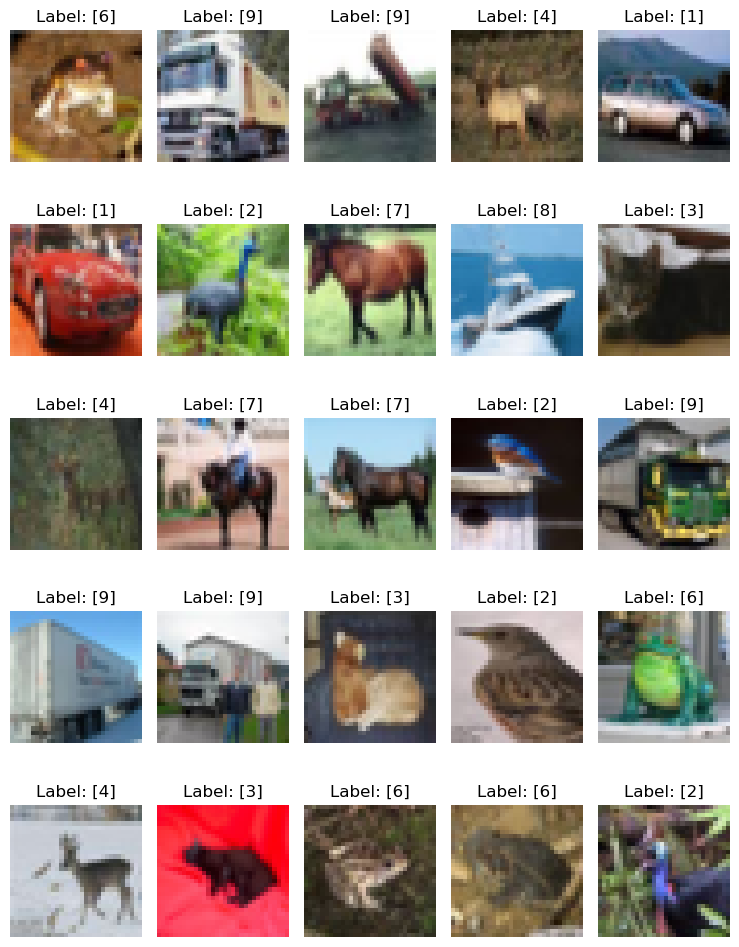

In [5]:
# Hacemos un cálculo del numero de clases máximo que tiene nuestro dataset de entrenamiento
num = 25
images = x_train[:num]
labels = y_train[:num]
num_row = 5
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
    ax.axis('off')
plt.tight_layout()
plt.show()

## Preparacion de los datos
En el caso de las imagenes a color, tenemos 3 canales: RGB
- Rojo
- Verde
- Azul

Cada pixel de esa imagen se le corresponden tres valores. En particular, estas imágenes también son de 8 bit, por lo tanto tenemos 3 valores entre 0 y 255 para cada uno de esos canales. Con eso está determinada la tonalidad.
Esto es importante porque son las dimensiones de entradas de esas imágenes

In [6]:
# La preparacion de los datos es muy similar
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [7]:
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes) #one-hot encoding

In [8]:
# Aplastamos la imagen y aplastamos cada canal
x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
x_test = x_test.reshape(x_test.shape[0], np.prod(x_test.shape[1:]))

In [9]:
x_train.shape

(50000, 3072)

## Modelo de redes densas

In [10]:
# Model -- MISMO MODELO QUE LA CLASE PASADA
#---------------------------------------------------------------------#
input_layer = Input(shape=x_train.shape[1:])
dense_1 = Dense(500, activation='relu') (input_layer)
dropout_1 = Dropout(0.25) (dense_1)
dense_2 = Dense(500, activation='relu') (dropout_1)
dropout_2 = Dropout(0.25) (dense_2)
dense_3 = Dense(500, activation='relu') (dropout_2)
dropout_3 = Dropout(0.25) (dense_3)
output_layer = Dense(n_classes, activation='softmax') (dropout_3)
#---------------------------------------------------------------------#
model_dense = Model(input_layer, output_layer)

In [11]:
Adadelta_optimizer = Adadelta(learning_rate=lr, rho=0.95)
model_dense.compile(optimizer=Adadelta_optimizer, loss='categorical_crossentropy', metrics=['acc', 'mse'])
model_dense.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 dense (Dense)               (None, 500)               1536500   
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 500)               250500    
                                                                 
 dropout_2 (Dropout)         (None, 500)               0     

## Entrenar el modelo

In [12]:
start_time = time.time()
history_dense = model_dense.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), shuffle=True, verbose=1)
end_time = time.time()
print('\nElapsed Dense Model training time: {:.5f} seconds'.format(end_time-start_time))

# Se obtiene una accuracy relativamente baja, pq las imagenes
# tienen info más compleja que la que veníamos trabajando anteriormente

Epoch 1/5
1563/1563 [==============================] - 167s 95ms/step - loss: 2.0663 - acc: 0.2178 - mse: 0.0850 - val_loss: 1.9173 - val_acc: 0.2822 - val_mse: 0.0814
Epoch 2/5
1563/1563 [==============================] - 130s 83ms/step - loss: 1.9553 - acc: 0.2665 - mse: 0.0822 - val_loss: 1.9229 - val_acc: 0.2953 - val_mse: 0.0813
Epoch 3/5
1563/1563 [==============================] - 131s 84ms/step - loss: 1.9135 - acc: 0.2915 - mse: 0.0810 - val_loss: 1.8157 - val_acc: 0.3463 - val_mse: 0.0782
Epoch 4/5
1563/1563 [==============================] - 127s 81ms/step - loss: 1.8795 - acc: 0.3139 - mse: 0.0798 - val_loss: 1.8063 - val_acc: 0.3404 - val_mse: 0.0779
Epoch 5/5
1563/1563 [==============================] - 140s 90ms/step - loss: 1.8468 - acc: 0.3302 - mse: 0.0788 - val_loss: 1.8304 - val_acc: 0.3430 - val_mse: 0.0782

Elapsed Dense Model training time: 698.03343 seconds


## Modelo de redes convolucionales

In [13]:
# Volvemos a cargar nuestro dataset
# recordemos que habíamos aplastado las imagenes, ahora con
# redes convolucionales trabajamos directamente con la imagen en 2D
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
n_classes = np.max(np.unique(y_train)) + 1

In [14]:
# Hacemos la misma normalizacion
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [15]:
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes) #one-hot encoding

Fijense que **no** trabajamos con los datos en 1D, sino con los datos en el formato de la imagen.

No hacemos el aplastamiento de la imagen que era necesario para trabajar con redes densas.

In [16]:
x_train.shape

(50000, 32, 32, 3)

In [17]:
# Model
#---------------------------------------------------------------------#
input_layer = Input(shape=x_train.shape[1:])

# Hacemos uso de la clase Conv2D, capa convolucional de dos dimensiones
# 1er argumento: nro de kernels
# 2do argumento: dimensión de los kernels (es de 3*3)
# 3er argumento: función de activación rampa
conv_1 = Conv2D(32, (3, 3), activation='relu') (input_layer)
conv_2 = Conv2D(64, (3, 3), activation='relu') (conv_1)

# Capa de MaxPooling2D
# a partir de unas dimensiones de pooling (2,2) nos quedamos con el
# pixel de mayor valor. Esos pixeles son neuronas de la capa de salida
# de convolución nro 2, pasados por la función de activación.
# ↓dimensiones de la red, salida con 64 canales de profundidad
pool_1 = MaxPooling2D(pool_size = (2, 2)) (conv_2)

# Dropout del 25%: 
# - ↓ complejidad computacional en entrenamiento
# - ↓ sobreajuste
dropout_1 = Dropout(0.25) (pool_1)

# Flatten
# aplastamos las dimensiones de la red. 
# lo que queremos hacer es pasarlo por una capa densa luego
flatten_1 = Flatten() (dropout_1)

dense_1 = Dense(100, activation='relu') (flatten_1)

dropout_2 = Dropout(0.25) (dense_1)

output_layer = Dense(n_classes, activation='softmax') (dropout_2)
#---------------------------------------------------------------------#
model_conv = Model(input_layer, output_layer)

# SI BIEN parece mas complejo, tenemos casi la mitad de parámetros entrenables
# que teníamos para las redes densas. de 2M a 1.2M de parametros entrenables
# el tiempo de ejecucion deberia ser significativamente menor

In [18]:
model_conv.compile(optimizer=Adadelta_optimizer, loss='categorical_crossentropy', metrics=['acc', 'mse'])
model_conv.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                           

In [21]:
Adadelta_optimizer = Adadelta(learning_rate=lr, rho=0.95)
model_conv.compile(optimizer=Adadelta_optimizer, loss='categorical_crossentropy', metrics=['acc', 'mse'])

# Llama a optimizer.build(variables) antes del bucle de entrenamiento
Adadelta_optimizer.build(model_conv.trainable_variables)

start_time = time.time()
history_conv = model_conv.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), shuffle=True, verbose=1)
end_time = time.time()
print('\nElapsed Dense Model training time: {:.5f} seconds'.format(end_time-start_time))

Epoch 1/5
1563/1563 [==============================] - 225s 140ms/step - loss: 1.5240 - acc: 0.4518 - mse: 0.0675 - val_loss: 1.1558 - val_acc: 0.5904 - val_mse: 0.0540
Epoch 2/5
1563/1563 [==============================] - 227s 145ms/step - loss: 1.1095 - acc: 0.6129 - mse: 0.0515 - val_loss: 0.9848 - val_acc: 0.6524 - val_mse: 0.0466
Epoch 3/5
1563/1563 [==============================] - 241s 154ms/step - loss: 0.9649 - acc: 0.6657 - mse: 0.0453 - val_loss: 0.9443 - val_acc: 0.6691 - val_mse: 0.0445
Epoch 4/5
1563/1563 [==============================] - 244s 156ms/step - loss: 0.8585 - acc: 0.7029 - mse: 0.0408 - val_loss: 0.8976 - val_acc: 0.6852 - val_mse: 0.0426
Epoch 5/5
1563/1563 [==============================] - 241s 154ms/step - loss: 0.7807 - acc: 0.7312 - mse: 0.0373 - val_loss: 0.9066 - val_acc: 0.6957 - val_mse: 0.0421

Elapsed Dense Model training time: 1182.83934 seconds


## Evaluar el proceso de entrenamiento

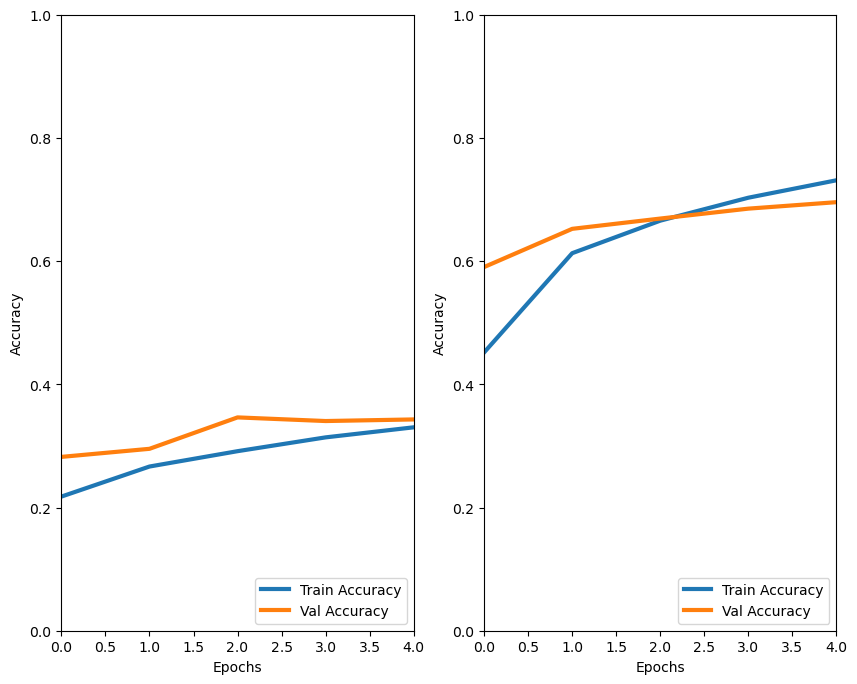

In [22]:
f = plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.plot(history_dense.history['acc'], linewidth=3, label='Train Accuracy')
plt.plot(history_dense.history['val_acc'], linewidth=3, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.axis([0, 4, 0, 1])
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history_conv.history['acc'], linewidth=3, label='Train Accuracy')
plt.plot(history_conv.history['val_acc'], linewidth=3, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.axis([0, 4, 0, 1])
plt.legend(loc='lower right')

plt.show()

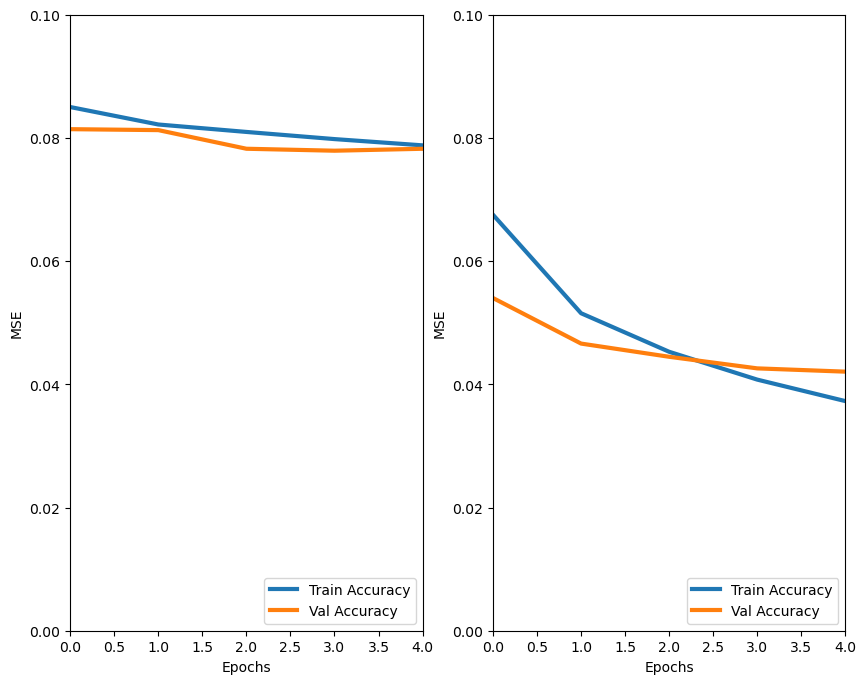

In [23]:
f = plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.plot(history_dense.history['mse'], linewidth=3, label='Train Accuracy')
plt.plot(history_dense.history['val_mse'], linewidth=3, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.axis([0, 4, 0, 0.1])
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history_conv.history['mse'], linewidth=3, label='Train Accuracy')
plt.plot(history_conv.history['val_mse'], linewidth=3, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.axis([0, 4, 0, 0.1])
plt.legend(loc='lower right')

plt.show()